# Type Annotations

## Dictionary
Dosn't check if the data is the correct type structure

## Typed Dictionary
- define explicitly what the data structure is
- makes debugging easier

```python
from typing import TypedDict


class ClassName(TypedDict):
    first_attribute: str
    second_attribute: int


class_instance = ClassName(
    first_attribute="String",
    second_attribute=1,
)
```

## Union
- used to define a value to be more than one type

## Optional
- used to set the type of a value to be None is is not declared

## Any
- used to allow any type for a value

## Lambda Function
- is a shortcut to write a small function

# Elements

## State
- the State is a shared data structure
- is like the appication memory

## Node
- Nodes are individual functions or operations

## Graph
- Graphs represents the strcture that maps how Nodes are connected and executed

## Edges
- Edges represents the connections between Nodes

## Conditional Edges
- specialized connections that decide the next Node to execute based on conditions or logics applied to the current state

## START
- is the entry point in LangGraph
- it dosn't perform any operation

## END
- is the exit point in LangGraph

## Tools
- specialized functions or utilities
- provide aditional functionalities

## ToolNode
- specilized Node to run a Tool
- connects the Tool's output back into the State

## StateGraph
- class in LangGraph used to build and compile the Graph structure

## Runnable
- standardized executable component that performs a speciic task within an AI workflow

## Messages
- Human Message: input from user
- AI Message: response generated by AI models
- System Message: provide instructions or context to the model
- Tool Message: result of the tool ussage
- Function Message: result of a function call

# Hello World Agent

## Single Input Graph

In [17]:
from typing import TypedDict
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    message: str


def greeting_node(state: AgentState) -> AgentState:
    """Simple Node that adds a greting message to the state"""

    state["message"] = "Hey! " + state["message"]
    return state


graph = StateGraph(AgentState)

graph.set_entry_point("greeter")
graph.add_node("greeter", greeting_node)
graph.set_finish_point("greeter")

app = graph.compile()

result = app.invoke({"message": "Hello World"})
result["message"]


'Hey! Hello World'

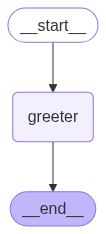

In [16]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Multiple Inputs Graph

In [25]:
from typing import TypedDict, List
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    values: List[int]
    name: str
    result: str


def process_values(state: AgentState) -> AgentState:
    """Function to handle multiple different inputs."""

    print(state)
    state["result"] = (
        f"Hi there {state['name']}. Your sum = {sum(state['values'])} !",
    )
    print(state)

    return state


graph = StateGraph(AgentState)

graph.set_entry_point("procesor")
graph.add_node("procesor", process_values)
graph.set_finish_point("procesor")

app = graph.compile()

answer = app.invoke({"values": [1, 2, 3, 4], "name": "Steve"})

print(answer)
print(answer["result"])


{'values': [1, 2, 3, 4], 'name': 'Steve'}
{'values': [1, 2, 3, 4], 'name': 'Steve', 'result': ('Hi there Steve. Your sum = 10 !',)}
{'values': [1, 2, 3, 4], 'name': 'Steve', 'result': ('Hi there Steve. Your sum = 10 !',)}
('Hi there Steve. Your sum = 10 !',)


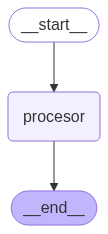

In [19]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Sequential Graph

In [31]:
from typing import TypedDict
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    name: str
    age: str
    final: str


def first_node(state: AgentState) -> AgentState:
    """This is the first node."""

    state["final"] = f"Hi {state['name']}. "
    return state


def second_node(state: AgentState) -> AgentState:
    """This is the second node."""

    state["final"] += f"You are {state['age']} years old!"
    return state


graph = StateGraph(AgentState)

graph.set_entry_point("first_node")
graph.add_node("first_node", first_node)
graph.add_edge("first_node", "second_node")
graph.add_node("second_node", second_node)
graph.set_finish_point("second_node")

app = graph.compile()

result = app.invoke({"name": "Bob", "age": 20})
print(result["final"])


Hi Bob. You are 20 years old!


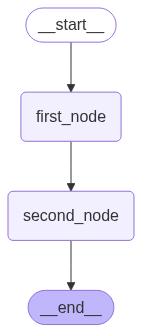

In [29]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Conditional Graph

In [35]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class AgentState(TypedDict):
    number_1: int
    operation: str
    number_2: int
    final_number: int


def adder(state: AgentState) -> AgentState:
    """Funtion to add two numbers."""

    state["final_number"] = state["number_1"] + state["number_2"]

    return state


def subtractor(state: AgentState) -> AgentState:
    """Funtion to subtract two numbers."""

    state["final_number"] = state["number_1"] - state["number_2"]

    return state


def decide_next_node(state: AgentState) -> AgentState:
    """This node will select the next node of the graph."""

    if state["operation"] == "+":
        return "addition_operation"
    elif state["operation"] == "-":
        return "subtraction_operation"


graph = StateGraph(AgentState)

graph.add_edge(START, "router")
graph.add_node("router", lambda state: state)
graph.add_conditional_edges(
    "router",
    decide_next_node,
    {"addition_operation": "add_node", "subtraction_operation": "sub_node"},
)
graph.add_node("add_node", adder)
graph.add_node("sub_node", subtractor)

graph.add_edge("add_node", END)
graph.add_edge("sub_node", END)

app = graph.compile()

initial_state_1 = AgentState(
    number_1=1,
    operation="+",
    number_2=2,
)
print(app.invoke(initial_state_1))


{'number_1': 1, 'operation': '+', 'number_2': 2, 'final_number': 3}


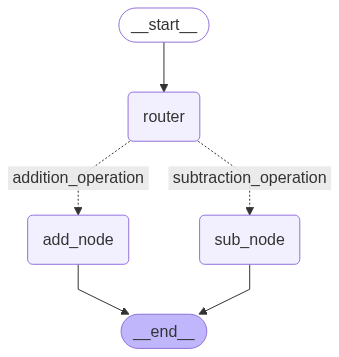

In [34]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Looping Graph 

In [44]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
import random


class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int


def greeting_node(state: AgentState) -> AgentState:
    """Greeting node."""

    state["name"] = f"Hi, {state['name']}"
    state["counter"] = 0

    return state


def random_node(state: AgentState) -> AgentState:
    """Generate a random number."""

    state["number"].append(random.randint(0, 10))
    state["counter"] += 1

    return state


def shoud_continue(state: AgentState) -> AgentState:
    """What to do next."""
    if state["counter"] < 5:
        print("Entering loop", state["counter"])
        return "loop"
    else:
        return "exit"


graph = StateGraph(AgentState)

graph.set_entry_point("greeting")
graph.add_node("greeting", greeting_node)
graph.add_edge("greeting", "random")
graph.add_node("random", random_node)
graph.add_conditional_edges(
    "random",
    shoud_continue,
    {"loop": "random", "exit": END},
)

app = graph.compile()

app.invoke({"name": "Steve", "number": [], "counter": -1})


Entering loop 1
Entering loop 2
Entering loop 3
Entering loop 4


{'name': 'Hi, Steve', 'number': [9, 8, 4, 0, 4], 'counter': 5}

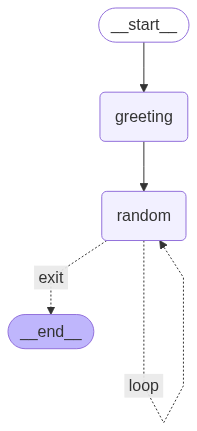

In [41]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())
